Forecasting wind turbines power output using deep learning (LSTM model).

For this project I will use Amit Bharadwa's wrangled and processed data and also use the their medium article as a guide (and I have familiarized myself with, and reproduced, all the preprocessing and EDA done on the data).
Their code for the data wrangling can be found here: https://github.com/Amitdb123/Forecasting-Wind-Turbine-Power-/blob/main/Data-Wrangling-EDA.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#importing data and splitting into train and test (Jan-Nov for training, December for testing)
df = pd.read_csv('hourly_nm.csv', index_col='Date/Time')

start_test = '2018-11-31'

train, test = df.loc[:start_test],df.loc[start_test:]
#scaling the data
from sklearn.preprocessing import MinMaxScaler

SCALER = MinMaxScaler(feature_range=(-1,1))
scaler = SCALER.fit(train.to_numpy())

train_scaled = scaler.transform(train.to_numpy())
test_scaled = scaler.transform(test.to_numpy())

#creating the input for the LSTM model


timestep = 24*7*2 # 24hours,7days,2weeks
def create_dataset(dataset, timestep=timestep):
    
    X, y = [], []
    for i in range(len(dataset)):
        target_value = i + timestep
        if target_value == len(dataset):
            break
        feature_chunk, target = dataset[i:target_value, 1:],   dataset[target_value, 0]
        X.append(feature_chunk)
        y.append(target)
    
    return np.array(X), np.array(y)

#spliting the data further by predictor and target variables

X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
df.head()

(7679, 336, 6)
(7679,)
(408, 336, 6)
(408,)


,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-01-01 01:00:00,460.537125,5.644205,513.418408,52.881284,-1.068567,-5.515860,390.480362
2018-01-01 02:00:00,733.655375,6.452037,788.401310,54.745935,-0.176225,-6.440522,460.537125
2018-01-01 03:00:00,909.362081,6.811455,948.793346,39.431265,-1.652917,-6.596464,733.655375
2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,12.873607,-2.912491,-7.138868,909.362081
2018-01-01 05:00:00,1149.599162,7.236854,1128.194441,-21.404721,-3.170687,-6.478943,1393.518188


In [4]:
#creating the model
import keras
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
def create_model(X_train, y_train):
        
        units = 32
        dropout = 0.05
        epochs = 35
        batch_size = 14
        optimizer = keras.optimizers.Adam(learning_rate=0.0005)
        early_stopping = EarlyStopping(patience=7, monitor='loss')        
        model = keras.Sequential()        
        model.add(LSTM(units=units, dropout=dropout, return_sequences=True,input_shape=(X_train.shape[1],    X_train.shape[2])))
        
        model.add(LSTM(units=units, dropout=dropout))
        
        model.add(Dense(units=1))        
        
        model.compile(optimizer=optimizer,loss='mean_squared_error')
        
        history = model.fit(X_train, y_train, validation_split=0.3, shuffle=False, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
       
        return model, history

def single_prediction(model, history, timestep=timestep):
        
        history = np.array(history)
        history = history.reshape(history.shape[0]*history.shape[1],   history.shape[2])
        
        input_value = history[-timestep:]
        input_value = input_value.reshape(1, input_value.shape[0], input_value.shape[1])
        
        yhat = model.predict(input_value, verbose=0)
        return yhat

#function for walk-forward validation

def walk_forward_prediction(X_train, y_train, X_test, timestep):
    
    MODEL, history = create_model(X_train=X_train, y_train=y_train)
    hist_train = [i for i in X_train]
    predictions = []
    
    for i in range(len(X_test)):
        test = X_test[i]
        yhat = single_prediction(model=MODEL, history=hist_train, timestep=timestep)
        predictions.append(yhat) 
        hist_train.append(test)
    
    return predictions, history, MODEL

#since the data is currently between 1 and -1, we need a function to reverse the prediction results to meaningful outputs
def prior_inverse(features, targets):
   
    dataset = []
    
    for i in range(features.shape[0]):
        last_row, target = features[i][0], targets[i]
        appended = np.append(last_row, target)
        dataset.append(appended)
    
    return np.array(dataset)

#putting everything together
def experiment(X_train, y_train, X_test, timestep):
    
    pred_seq, history, MODEL = walk_forward_prediction(X_train, y_train, X_test, timestep)
    
    pred_seq = np.array(pred_seq).reshape(-1)    
    pred = prior_inverse(X_test, pred_seq)
    real = prior_inverse(X_test, y_test)    
    inv_pred = scaler.inverse_transform(pred)
    inv_real = scaler.inverse_transform(real)    
    power_pred = inv_pred[:,-1]
    power_real = inv_real[:,-1]
    
    return power_real, power_pred, history, MODEL

power_real, power_pred, history, MODEL = experiment(X_train, y_train, X_test, timestep)
loss = history.history['loss']
val_loss = history.history['val_loss']



Using TensorFlow backend.


Train on 5375 samples, validate on 2304 samples
Epoch 1/35
5375/5375 [==============================] - 87s 16ms/step - loss: 0.2269 - val_loss: 0.1682
Epoch 2/35
5375/5375 [==============================] - 86s 16ms/step - loss: 0.1437 - val_loss: 0.1084
Epoch 3/35
5375/5375 [==============================] - 90s 17ms/step - loss: 0.1028 - val_loss: 0.0778
Epoch 4/35
5375/5375 [==============================] - 88s 16ms/step - loss: 0.0874 - val_loss: 0.0676
Epoch 5/35
5375/5375 [==============================] - 89s 17ms/step - loss: 0.0793 - val_loss: 0.0667
Epoch 6/35
5375/5375 [==============================] - 80s 15ms/step - loss: 0.0765 - val_loss: 0.0646
Epoch 7/35
5375/5375 [==============================] - 80s 15ms/step - loss: 0.0759 - val_loss: 0.0635
Epoch 8/35
5375/5375 [==============================] - 80s 15ms/step - loss: 0.0723 - val_loss: 0.0638
Epoch 9/35
5375/5375 [==============================] - 80s 15ms/step - loss: 0.0737 - val_loss: 0.0650
Epoch 10/35
5375

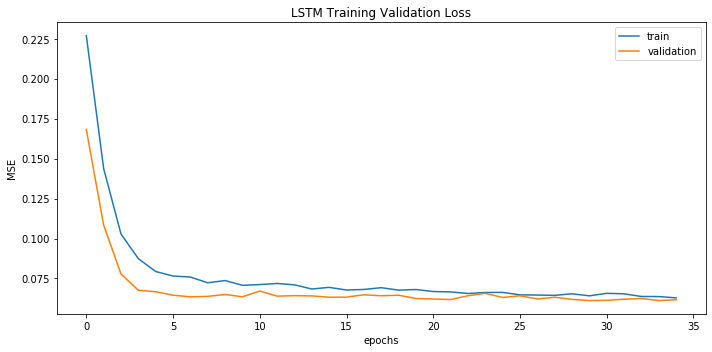

In [5]:
#plot validation and training convergence graph
plt.figure(figsize=(10,5))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('LSTM Training Validation Loss')
plt.tight_layout()
plt.savefig('train_val_plot.png')
plt.show()

In [6]:
x_plot = test[timestep:].index
pred_df = pd.DataFrame({'Date':x_plot, 'Prediction': power_pred, 'True': power_real})
pred_df.set_index('Date', inplace=True)

In [7]:
pred_df2 = pred_df['2018-12-15 01:00:00	':'2018-12-29 02:00:00 ']

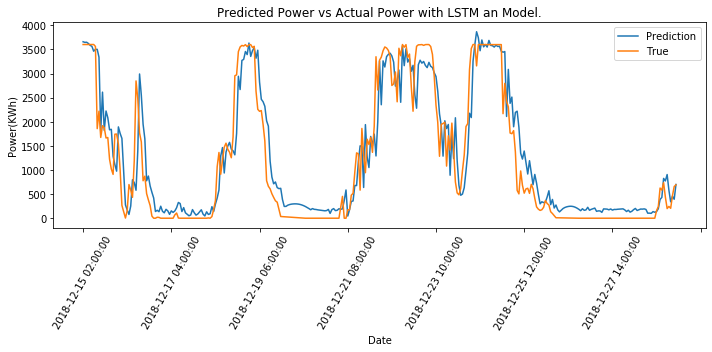

In [8]:
#plot predictions
pred_df2.plot(rot='60',figsize=(10,5))
plt.title('Predicted Power vs Actual Power with LSTM an Model.')
plt.ylabel('Power(KWh)')
plt.tight_layout()
plt.savefig('prediction.png')
plt.show()